In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

In [2]:
def gtrace(x):

    return -1 / 1200.0 * (x - 480.0) ** 2 + 200


def adjustment(x, y, p=0.7):

    return p * (gtrace(x) - y)


def wavelength_solution(x, p=[1.1, 1.1]):

    return p[0] * x + p[1]


def function(x, y):
    # first term is adjust mean term
    # second term is a wavelength solution
    return wavelength_solution(adjustment(x, y) + x)


def amplitudes(x, y):

    return np.exp(-((gtrace(x) - y) ** 2) / 10000)


def flux_model(l):

    return np.ones(l.shape)


def resolving(x, y):
    l = function(x, y)
    a = amplitudes(x, y)
    f = a * flux_model(l)
    return f, a, l

In [3]:
xs = np.arange(0, 1080, dtype=int)
ys = np.arange(0, 360, dtype=int)
XS, YS = np.meshgrid(xs, ys)

In [4]:
# f.shape, XS.shape, YS.shape

Text(0, 0.5, '$y$ (pix)')

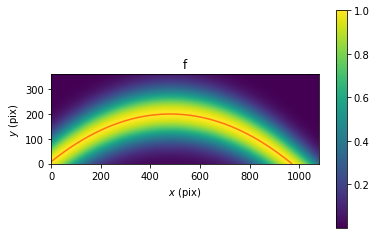

In [5]:
f, a, l = resolving(XS, YS)
imshowkwargs = {"origin": "lower", "interpolation": "nearest"}
plt.title("f")
plt.imshow(f, **imshowkwargs)
plt.plot(
    xs[np.where(gtrace(xs) > 0)], gtrace(xs)[np.where(gtrace(xs) > 0)], "r-", alpha=0.5
)
plt.xlim(-0.5, len(xs) - 0.5)
plt.colorbar()
plt.xlabel(r"$x$ (pix)")
plt.ylabel(r"$y$ (pix)")

In [6]:
# Set defaults.
specvar = 5.0  # pixels ** 2
rng = np.random.default_rng(17)
TWOPI = 2.0 * np.pi
ONEOVERTWOPI = 1.0 / TWOPI

In [7]:
def gaussian_1d(xxs, mean, var):
    """
    `xxs`   should be shape `(nx, )`.
    `mean`  should be a scalar.
    `var`   should be a scalar.
    """
    return np.sqrt(ONEOVERTWOPI / var) * np.exp(-0.5 / var * (xxs - mean) ** 2)

In [8]:
def gaussian_func(xxs, mean, var):
    """
    `xxs`   should be shape `(nx, )`.
    `mean`  should be a scalar.
    `var`   should be a scalar.
    """
    return np.exp(-0.5 / var * (xxs - mean) ** 2)

In [9]:
import sys

sys.path.insert(0, "..")

In [10]:
import jabble.model
import jabble.loss
import jax
import jabble.dataset

In [11]:
class Resolving(jabble.model.ContainerModel):
    def __init__(self, trace, wave_sol, falloff, blurr, flux):
        super(Resolving, self).__init__([trace, wave_sol, falloff, blurr, flux])

    def call(self, p, x, y, i, *args):
        p0, p1, p2, p3, p4 = self.split_p(p)
        #         print(p1,p2,p3,p4,p5)
        # find trace
        a, b, xt = self.models[0](p0, x, y, i, *args)
        # use trace to fit 1d reduction
        # convert reduced latent variable to log lambda
        l = self.models[1](p1, xt, i, *args)
        # determined psf amplitude?
        # use log lambda to produce flux
        ap = self.models[2](p2, a, i, *args)
        ab, lb = self.models[3](p3, a, i, *args)

        f = self.models[4](p4, l + lb, i, *args)
        return (ap[None, ...] * ab * f).sum(axis=0)

In [12]:
import jax.nn

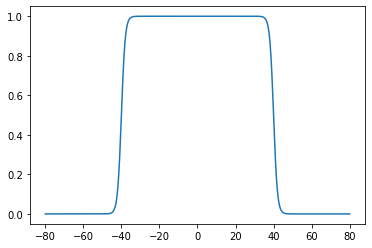

In [13]:
a = np.linspace(-80, 80, 1000)
temp = jax.nn.sigmoid(a + 40) * jax.nn.sigmoid(40 - a)
plt.plot(a, temp)

In [14]:
class Falloff(jabble.model.Model):
    def __init__(self, p):
        super(Falloff, self).__init__()
        self.p = p

    def call(self, p, a, i, *args):
        # p[0] is the best spectral resolution  at the center of the trace
        #         sigma = p[0] + p[1]*np.abs(a)/np.amax(a)
        #         spread_far_from_trace  = gaussian_func(np.arange(-self.n,self.n,step=1.0)[:,None,None], 0.0, sigma)

        #         spread_far_from_trace /= (spread_far_from_trace).sum(axis=0)

        # light cuts off at delta from a
        temp = jax.nn.sigmoid(a + p[0]) * jax.nn.sigmoid(p[0] - a)
        #         temp = np.ones(a.shape)
        #         temp[np.where(a**2 > p[2])] = 0
        return temp  # [None,...] * spread_far_from_trace


class BlurringModel(jabble.model.Model):
    def __init__(self, p, n, resolution):
        super(BlurringModel, self).__init__()
        self.p = p
        self.n = n
        self.dx = jabble.dataset.delta_x(resolution)

    def call(self, p, a, i, *args):
        sigma = p[0] + p[1] * np.abs(a) / np.amax(a)
        temp_x = np.arange(-self.n, self.n, step=1.0)[:, None, None]
        spread_far_from_trace = gaussian_func(temp_x, 0.0, sigma)

        imshowkwargs = {"origin": "lower", "interpolation": "nearest"}
        plt.imshow(sigma, **imshowkwargs)
        #         plt.plot(x[0,:],t,'r')
        plt.title("$\sigma$")
        plt.savefig("sigma.png")
        #         plt.colorbar()
        plt.show()

        spread_far_from_trace /= (spread_far_from_trace).sum(axis=0)
        return spread_far_from_trace, temp_x * self.dx

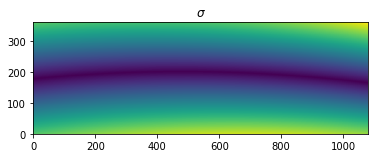

In [15]:
from functools import partial
import jax
import jax.numpy as jnp


class TraceModel(jabble.model.ContainerModel):
    def __init__(self, trace, vector):
        super(TraceModel, self).__init__([trace, vector])

    def call(self, p, x, y, i, *args):
        p0, p1 = self.split_p(p)
        vx, vy = self.models[1](p0, x[0, :], i)
        wx, wy = self.models[0].tangent(p1, x[0, :], i)

        t = self.models[0](p0, x[0, :], i)
        a = (t[None, ...] - y) / (
            vy[None, ...] - wy[None, ...] * vx[None, ...] / wx[None, ...]
        )
        b = -vx[None, ...] / wx[None, ...] * a
        xt = x + b * wx

        #         imshowkwargs = {"origin": "lower", "interpolation": "nearest"}
        #         plt.imshow(xt,**imshowkwargs)
        #         plt.plot(x[0,:],t,'r')
        #         plt.title('xt')
        #         plt.savefig('xt.png')
        # #         plt.colorbar()
        #         plt.show()

        #         plt.imshow(a,**imshowkwargs)
        #         plt.plot(x[0,:],t,'r')
        #         plt.title('a')
        #         plt.savefig('a_img.png')
        # #         plt.colorbar()
        #         plt.show()

        #         plt.imshow(b,**imshowkwargs)
        #         plt.plot(x[0,:],t,'r')
        #         plt.title('b')
        #         plt.savefig('b_img.png')
        # #         plt.colorbar()
        #         plt.show()

        return a, b, xt


class PolynomialModel(jabble.model.Model):
    def __init__(self, p):
        super(PolynomialModel, self).__init__()
        self.p = p

    def call(self, p, x, i, *args):

        return jnp.polyval(p, x)

    def grad(self, p, x, i, *args):

        return jnp.polyval(jnp.polyder(p, m=1), x)

    def _tangent(self, p, x, i, *args):

        dfdx = self.grad(p, x, i, *args)
        return 1 / np.sqrt(1 + dfdx**2), dfdx / np.sqrt(1 + dfdx**2)

    def tangent(self, p, *args):
        if len(p) == 0:
            assert self._fit == False
            return self._tangent(self.p, *args)
        else:
            assert self._fit == True
            return self._tangent(p, *args)


class LinearAngular(jabble.model.Model):
    def __init__(self, p):
        super(LinearAngular, self).__init__()
        self.p = p

    def call(self, p, x, i, *args):

        return jnp.cos(jnp.polyval(p, x)), jnp.sin(jnp.polyval(p, x))


xdata = np.linspace(np.log(4900), np.log(4910), 1000)
lines = [np.log(4903), np.log(4906)]
spread = (np.max(xdata) - np.min(xdata)) * 1e-7
ydata = np.ones(xdata.shape)
for line in lines:
    ydata -= 1 * gaussian_func(xdata, line, spread)

m = (np.max(xdata) - np.min(xdata)) / (np.max(xs) - np.min(xs))
b = np.min(xdata) - m * np.min(xs)

# trace = TraceModel([-1e-4,-480.0,200,1e-8,-np.pi/4])
trace = PolynomialModel([-1e-4, -1e-4 * 2 * -480.0, 200 + -1e-4 * 480.0**2])
vect_trace = TraceModel(trace, LinearAngular([1e-8, -np.pi / 4]))
amp = Falloff(p=[40])
blurr = BlurringModel([1.0, 1e2], n=10, resolution=120_000)
shifts = [0.0]
rvs = jabble.model.ShiftingModel(shifts)
wave_sol = jabble.model.CompositeModel([PolynomialModel(p=[m, b]), rvs])
flux = jabble.model.JaxLinear(xs=xdata, p=ydata)

mean_model = Resolving(vect_trace, wave_sol, amp, blurr, flux)
fhat = mean_model([], XS, YS, 0)

In [16]:
np.min(xs), np.max(xs)

(0, 1079)

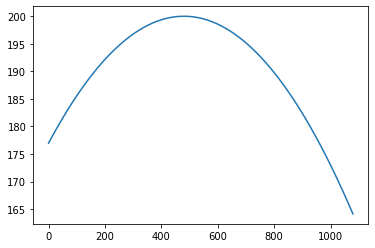

In [17]:
plt.plot(xs, trace([], xs, 0))

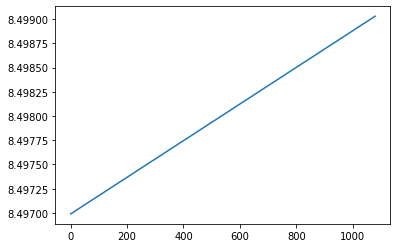

In [18]:
plt.plot(xs, wave_sol([], xs, 0))

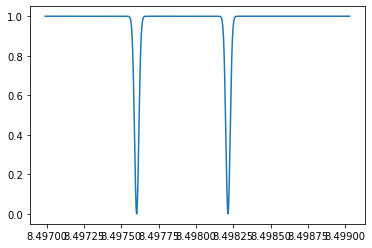

In [19]:
plt.plot(xdata, ydata)

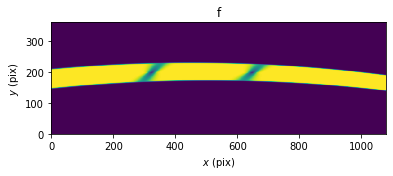

In [20]:
# f,a,l = resolving(XS,YS)
imshowkwargs = {"origin": "lower", "interpolation": "nearest"}
plt.title("f")
plt.imshow(fhat, **imshowkwargs)
# plt.plot(xs[np.where(trace([],xs,0)[0] > 0)], trace([],xs,0)[0][np.where(trace([],xs,0)[0] > 0)], "r-", alpha=0.5)
# plt.xlim(-0.5, len(xs)-0.5)
# plt.colorbar()
plt.xlabel(r"$x$ (pix)")
plt.ylabel(r"$y$ (pix)")
plt.savefig("fake_data.png")

In [21]:
class TwoDLoss(jabble.loss.LossFunc):
    def loss_all(self, p, data, model):
        for ind in range(data.epoches):

            output += self(p, data, ind, model, *args).sum()

        return output


class L2D2(TwoDLoss):
    def __call__(self, p, data, i, model, *args):
        err = self.coefficient * ((data.fs[i, :] - model(p, data, i, *args)) ** 2)
        return err

In [22]:
class Data:
    def __init__(self, xs, ys, fs, epoches=1):
        self.xs = xs
        self.ys = ys
        self.fs = fs
        self.epoches = epoches

In [23]:
mean_model.display()

-Resolving----------------------------------------0
  0-TraceModel------------------------------------0
  0  0-PolynomialModel---------------------------------------------0
  0  1-LinearAngular-----------------------------------------------0
  1-CompositeModel-------------------------------------------------0
  1  0-PolynomialModel---------------------------------------------0
  1  1-ShiftingModel-----------------------------------------------0
  2-Falloff---------------------------------------0
  3-BlurringModel--------------------------------------------------0
  4-JaxLinear-------------------------------------0


In [24]:
from astropy.io import fits

In [25]:
fluxfile = fits.open(
    "../../KeckData/KOA_104934/HIRES/extracted/binaryfits/ccd1/flux/HI.20190818.20089_1_01_flux.fits"
)
arcfile = fits.open(
    "../../KeckData/KOA_104934/HIRES/extracted/binaryfits/ccd1/arcids/HI.20190818.20089_1_01_arcids.fits"
)
hdrfile = fits.open(
    "../../KeckData/KOA_104934/HIRES/extracted/binaryfits/ccd1/hdr/HI.20190818.20089_1_01_hdr.fits"
)
profile = fits.open(
    "../../KeckData/KOA_104934/HIRES/extracted/binaryfits/ccd1/profile/HI.20190818.20089_1_01_profile.fits"
)
tracfile = fits.open(
    "../../KeckData/KOA_104934/HIRES/extracted/binaryfits/ccd1/trace/HI.20190818.20089_1_01_trace.fits"
)

rawfile = fits.open("../../KeckData/KOA_104934/HIRES/raw/sci/HI.20190818.20089.fits")

In [28]:
len(rawfile)

4

In [26]:
fluxfile[0].header

SIMPLE  =                    T / Java FITS: Wed Aug 21 08:07:11 HST 2019        
BITPIX  =                  -32                                                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
DATE    = '2019-08-18T05:35:04' /  file creation date (YYYY-MM-DDThh:mm:ss UT)  
DETCNFID=                 1002 / mosaic detector configuration Id               
DETCNFIG= 'HIRES Science mosaic' /  mosaic detector configuration               
MOSAIC  = 'HIRES Science Mosaic' /  mosaic detector                             
MOSDESIN= 'HIRES Mosaic'       /  mosaic detector design                        
AMPWIRES= 'HIRES Wiring, 6-amplifier' /  mosaic amplifier wiring                
VIDEOINP=                    2 / see HIRES engineering drawing H9604            
AMPLOC  = '2       '           /  see HIRES engineering drawing H9604           
AMPTYPE = 'B       '        

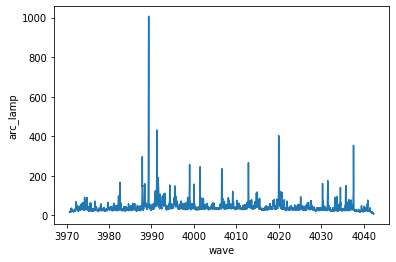

In [27]:
key = "arc_lamp"
plt.plot(fluxfile[1].data["wave"], fluxfile[1].data[key])
plt.xlabel("wave")
plt.ylabel(key)
plt.savefig("keck_{}.png".format(key))
plt.show()

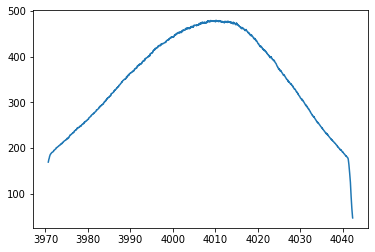

In [28]:
plt.plot(fluxfile[1].data["wave"], fluxfile[1].data["Flat"])

In [29]:
fluxfile[1].header

XTENSION= 'BINTABLE'           / Java FITS: Wed Aug 21 08:07:11 HST 2019        
BITPIX  =                    8                                                  
NAXIS   =                    2 / Dimensionality                                 
NAXIS1  =                   96                                                  
NAXIS2  =                 4056                                                  
PCOUNT  =                    0                                                  
GCOUNT  =                    1                                                  
TFIELDS =                   12                                                  
TFORM1  = '1D      '                                                            
TTYPE1  = 'col     '           / col                                            
TFORM2  = '1D      '                                                            
TTYPE2  = 'row     '           / row                                            
TFORM3  = '1D      '        

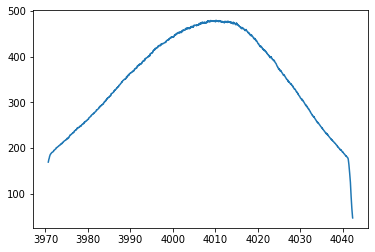

In [30]:
# print(keckfile[2].data.shape)
# keckfile[1].header
plt.plot(fluxfile[1].data["wave"], fluxfile[1].data["Flat"])

In [31]:
arcfile[1].header

XTENSION= 'BINTABLE'           / Java FITS: Wed Aug 21 08:07:10 HST 2019        
BITPIX  =                    8                                                  
NAXIS   =                    2 / Dimensionality                                 
NAXIS1  =                   96                                                  
NAXIS2  =                    5                                                  
PCOUNT  =                    0                                                  
GCOUNT  =                    1                                                  
TFIELDS =                   12                                                  
TFORM1  = '1D      '                                                            
TTYPE1  = 'col_cen '           / col_cen                                        
TFORM2  = '1D      '                                                            
TTYPE2  = 'row     '           / row                                            
TFORM3  = '1D      '        

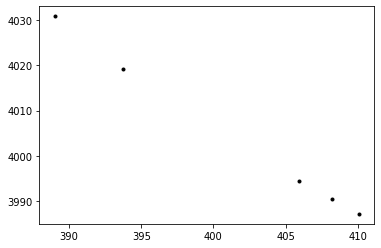

In [32]:
plt.plot(arcfile[1].data["raw_col"], arcfile[1].data["wave_exp"], ".k")

In [33]:
profile[1].header

XTENSION= 'BINTABLE'           / Java FITS: Wed Aug 21 08:07:10 HST 2019        
BITPIX  =                    8                                                  
NAXIS   =                    2 / Dimensionality                                 
NAXIS1  =                   24                                                  
NAXIS2  =                  376                                                  
PCOUNT  =                    0                                                  
GCOUNT  =                    1                                                  
TFIELDS =                    3                                                  
TFORM1  = '1D      '                                                            
TTYPE1  = 'relative_pixel'     / relative_pixel                                 
TFORM2  = '1D      '                                                            
TFORM3  = '1D      '                                                            
TTYPE2  = 'median_flux'     

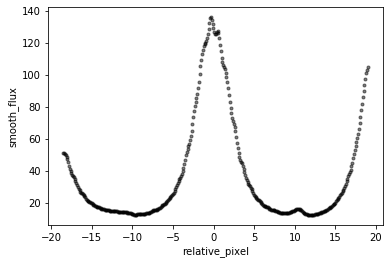

In [34]:
# profile[1].header
# plt.plot(profile[1].data['relative_pixel'],profile[1].data['median_flux'],'.r',alpha=0.5)
plt.plot(
    profile[1].data["relative_pixel"], profile[1].data["smooth_flux"], ".k", alpha=0.5
)
plt.xlabel("relative_pixel")
plt.ylabel("smooth_flux")
plt.savefig("keck_profile.png", dpi=200)
plt.show()

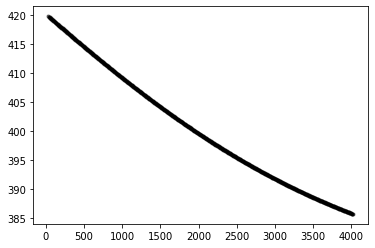

In [35]:
plt.plot(tracfile[1].data["raw_row"], tracfile[1].data["raw_col"], ".k", alpha=0.5)
# plt.plot(profile[1].data['relative_pixel'],profile[1].data['smooth_flux'],'-b',alpha=0.5)
plt.show()

In [36]:
tracfile[1].header

XTENSION= 'BINTABLE'           / Java FITS: Wed Aug 21 08:07:11 HST 2019        
BITPIX  =                    8                                                  
NAXIS   =                    2 / Dimensionality                                 
NAXIS1  =                   80                                                  
NAXIS2  =                  799                                                  
PCOUNT  =                    0                                                  
GCOUNT  =                    1                                                  
TFIELDS =                   10                                                  
TFORM1  = '1D      '                                                            
TTYPE1  = 'col     '           / col                                            
TFORM2  = '1D      '                                                            
TTYPE2  = 'row     '           / row                                            
TFORM3  = '1D      '        

In [37]:
rawfile[1].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  713 / length of data axis 1                          
NAXIS2  =                 4096 / length of data axis 2                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
DATE    = '2019-08-18T05:35:04' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
BLANK   =               -32768 / FITS array value of NULL pixel                 
EXTNAME = 'VidInp2 '           / name of this image extension                   
DETCNFID=                 10

In [38]:
# imshowkwargs = {"origin": "lower", "interpolation": "nearest"}
# fig, ax = plt.subplots(figsize=(18, 2))
# ax.set_title("keck raw data")
# # plt.figure(figsize=(5,7))
# ax.imshow(rawfile[1].data[1000:4000,240:290].T, **imshowkwargs)
# # plt.plot(xs[np.where(trace([],xs,0)[0] > 0)], trace([],xs,0)[0][np.where(trace([],xs,0)[0] > 0)], "r-", alpha=0.5)
# # plt.xlim(-0.5, len(xs)-0.5)
# # plt.colorbar()
# plt.xlabel(r"$x$ (pix)")
# plt.ylabel(r"$y$ (pix)")

In [39]:
class L2Func(jabble.loss.LossFunc):
    def __call__(self, p, data, i, model):
        return ((data.ys[i, :] - model(p, data.xs[i, :], i)) ** 2).sum(axis=0)


lossfunction = L2Func()

In [40]:
import scipy.optimize

In [41]:
class Data1d:
    def __init__(self, xs, ys):
        self.xs = xs.astype(np.float64)
        self.ys = ys.astype(np.float64)
        self.mask = np.zeros(xs.shape).astype(bool)

In [42]:
wavedata = Data1d(
    arcfile[1].data["raw_row"][None, :], arcfile[1].data["wave_obj"][None, :]
)

In [43]:
wav_sol = PolynomialModel(
    [4000, 20 / 2000, 0]
)  # jabble.model.JaxLinear(xs=np.linspace(wavedata.xs.min(),wavedata.xs.max(),5))
wav_sol.fit()
wav_sol.optimize(lossfunction, wavedata, bounds=None, method="BFGS")

      fun: 0.01334989070892334
 hess_inv: array([[ 3.78215215e-13, -1.54956776e-09,  1.39927197e-06],
       [-1.54956776e-09,  6.42748208e-06, -5.90818999e-03],
       [ 1.39927197e-06, -5.90818999e-03,  5.66519175e+00]])
      jac: array([6.53762500e+03, 2.40077209e+00, 9.76562500e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 70
      nit: 14
     njev: 58
   status: 2
  success: False
        x: array([-5.80905970e-07,  1.97990582e-02,  3.97024316e+03])

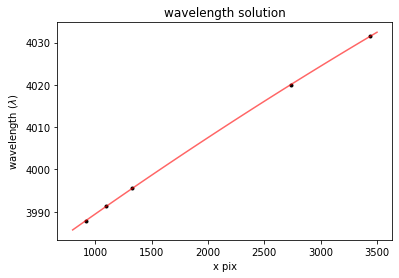

In [44]:
xspace = np.linspace(800, 3500)
wav_sol.fix()
plt.plot(wavedata.xs[0, :], wavedata.ys[0, :], ".k")
plt.plot(xspace, wav_sol([], xspace, 0), "-r", alpha=0.6)
plt.xlabel("x pix")
plt.ylabel("wavelength ($\lambda$)")
plt.title("wavelength solution")
plt.savefig("keck_wavesol.png", dpi=200)

In [45]:
tracfile[1].header

XTENSION= 'BINTABLE'           / Java FITS: Wed Aug 21 08:07:11 HST 2019        
BITPIX  =                    8                                                  
NAXIS   =                    2 / Dimensionality                                 
NAXIS1  =                   80                                                  
NAXIS2  =                  799                                                  
PCOUNT  =                    0                                                  
GCOUNT  =                    1                                                  
TFIELDS =                   10                                                  
TFORM1  = '1D      '                                                            
TTYPE1  = 'col     '           / col                                            
TFORM2  = '1D      '                                                            
TTYPE2  = 'row     '           / row                                            
TFORM3  = '1D      '        

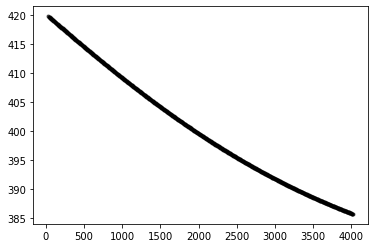

In [46]:
plt.plot(tracfile[1].data["raw_row"], tracfile[1].data["raw_col"], ".k", alpha=0.6)

In [47]:
tracedata = Data1d(
    tracfile[1].data["raw_row"][None, :], tracfile[1].data["raw_col"][None, :]
)

In [48]:
trace_model = PolynomialModel(
    [0, 35 / 4000, 240]
)  # jabble.model.JaxLinear(xs=np.linspace(wavedata.xs.min(),wavedata.xs.max(),5))
trace_model.fit()
trace_model.optimize(lossfunction, tracedata, bounds=None, method="BFGS")

      fun: 1.698028564453125
 hess_inv: array([[ 4.49533541e-16, -1.81654742e-12,  1.24992351e-09],
       [-1.81654742e-12,  7.81570486e-09, -6.00287417e-06],
       [ 1.24992351e-09, -6.00287417e-06,  5.97730569e-03]])
      jac: array([8.06040000e+04, 2.93457031e+01, 1.42211914e-02])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 72
      nit: 5
     njev: 61
   status: 2
  success: False
        x: array([ 8.63057561e-07, -1.20888716e-02,  4.20314964e+02])

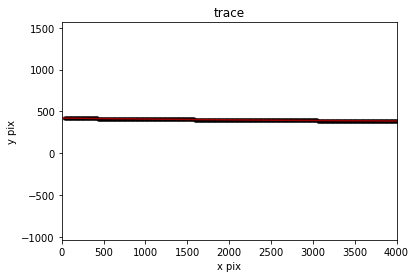

In [49]:
xspace = np.linspace(0, 4000)
trace_model.fix()
plt.title("trace")
plt.xlabel("x pix")
plt.ylabel("y pix")
plt.axis("equal")
plt.xlim(0, 4000)
plt.ylim(240, 290)

plt.plot(tracedata.xs[0, :], tracedata.ys[0, :], ".k", alpha=0.6)
plt.plot(xspace, trace_model([], xspace, 0), "-r", alpha=0.6)

plt.savefig("keck_trace_fit.png", dpi=200)
plt.show()

In [50]:
import scipy.ndimage

In [51]:
# pos_flux    = fluxfile[1].data['flux']
# pos_flux[np.where(pos_flux < -2.5e4)] = -2.5e4
# pos_flux -= np.min(pos_flux)
# smooth_flux = scipy.ndimage.gaussian_filter(pos_flux,100)
# normed_flux = pos_flux / smooth_flux
# profile[1].data['relative_pixel'],profile[1].data['smooth_flux']
# temp = jnp.arange(np.min(profile[1].data['relative_pixel']),np.max(profile[1].data['relative_pixel']),step=1.0,dtype='f8')
# kernel = jax.numpy.interp(temp, jnp.array(profile[1].data['relative_pixel'],dtype='f8'), jnp.array(profile[1].data['smooth_flux'],dtype='f8'))

# out      = np.array(jnp.convolve(jnp.array(fluxfile[1].data['Sum_Flux'],dtype='f8'),kernel,mode='same'))[None,:]
out = np.array(fluxfile[1].data["flux"])[None, ...]
out = (out - np.min(out)) / (np.max(out) - np.min(out))
fluxdata = Data1d(np.array(fluxfile[1].data["wave"])[None, :], out)

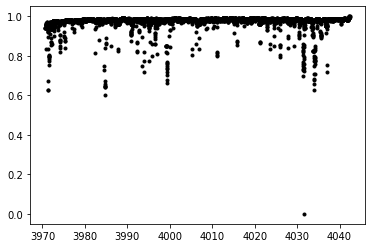

In [52]:
plt.plot(fluxdata.xs[0, :], fluxdata.ys[0, :], ".k")
# plt.xlim(3970,4020)
plt.show()

In [53]:
class testmodeljaxlinear(jabble.model.JaxLinear):
    def optimize(
        self,
        loss,
        data,
        method="L-BFGS-B",
        bounds=None,
        verbose=False,
        options={},
        save_history=False,
        save_loss=False,
        *args
    ):
        # Fits the Model
        self.save_history = save_history
        self.save_loss = save_loss
        # if loss is None:
        #     loss_ind = np.arange(data.shape[0])

        func_grad = jax.value_and_grad(loss.loss_all, argnums=0)

        def val_gradient_function(p, *args):
            val, grad = func_grad(p, *args)
            self.func_evals.append(val)
            if verbose:
                print(
                    "\r[ Value: {:+3.2e} Grad: {:+3.2e} ]".format(
                        val, np.inner(grad, grad)
                    )
                )

            if self.save_history:
                self.history.append(np.array(p))

            if self.save_loss:
                initialize = loss(p, data, 0, self)
                tmp = np.zeros((data.ys.shape[0], *initialize.shape))
                tmp[0, ...] = initialize
                for i in range(1, data.ys.shape[0]):
                    tmp[i, ...] = loss(p, data, i, self)
                self.loss_history.append(tmp)

            return np.array(val, dtype="f8"), np.array(grad, dtype="f8")

        res = scipy.optimize.minimize(
            val_gradient_function,
            self.get_parameters(),
            jac=True,
            method=method,
            args=(data, self, *args),
            options=options,
            bounds=bounds,
        )
        self.results.append(res)
        self.unpack(res.x)
        return res

In [54]:
flux_model = jabble.model.JaxLinear(xs=fluxdata.xs[0, :])
flux_model.fit()
flux_model.display()
res = flux_model.optimize(lossfunction, fluxdata, method="L-BFGS-B", verbose=True)
print(np.sqrt(np.mean(res["jac"] ** 2)))
print(res)

-JaxLinear-------------------------------------4056
[ Value: +3.84e+03 Grad: +1.54e+04 ]
[ Value: +3.72e+03 Grad: +1.49e+04 ]
[ Value: +3.25e+03 Grad: +1.30e+04 ]
[ Value: +1.68e+03 Grad: +6.72e+03 ]
[ Value: +1.98e-11 Grad: +7.94e-11 ]
1.398855050841358e-07
      fun: array(1.98419059e-11)
 hess_inv: <4056x4056 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        2.38418579e-07,  0.00000000e+00, -2.38418579e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 5
      nit: 2
     njev: 5
   status: 0
  success: True
        x: array([0.94239636, 0.94239636, 0.94239636, ..., 0.99958734, 0.99999998,
       0.9971186 ])


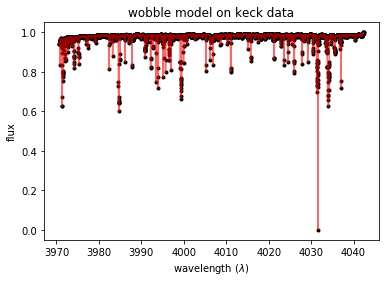

In [55]:
# xspace = np.linspace(0,4000)
flux_model.fix()
plt.title("wobble model on keck data")
plt.ylabel("flux")
plt.xlabel("wavelength ($\lambda$)")
plt.plot(fluxdata.xs[0, :], fluxdata.ys[0, :], ".k")
plt.plot(fluxdata.xs[0, :], flux_model([], fluxdata.xs[0, :], 0), "-r", alpha=0.6)
plt.savefig("keck_spectra.png", dpi=200)
plt.show()

In [56]:
# prof_model = jabble.model.BSpline()

In [57]:
# trace = PolynomialModel([-1e-4,-1e-4*2*-480.0,200 + -1e-4*480.0**2])
vect_trace_model = LinearAngular([0.0, np.pi / 2])
transform_model = TraceModel(trace_model, vect_trace_model)
# amp   = Falloff(p=[1.0,1.0e-2,2],n=1)

prof_model = Falloff(p=[2])
blurr = BlurringModel([1.0, 1e-2], n=1, resolution=200_000)

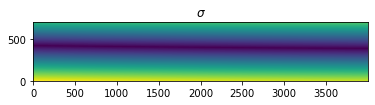

In [58]:
ys = np.arange(0, 700, 1.0)
xs = np.arange(0, 4000, 1.0)
Xs, Ys = np.meshgrid(xs, ys)
mean_model = Resolving(transform_model, wav_sol, prof_model, blurr, flux_model)
fhat = mean_model([], Xs, Ys, 0)

In [59]:
np.min(rawfile[1].data.T[240:290, 1000:1500]), np.max(
    rawfile[1].data.T[240:290, 1000:1500]
), np.min(fhat), np.max(fhat)

(930,
 2105,
 DeviceArray(0., dtype=float32),
 DeviceArray(0.7689998, dtype=float32))

In [60]:
import matplotlib.cm as cm

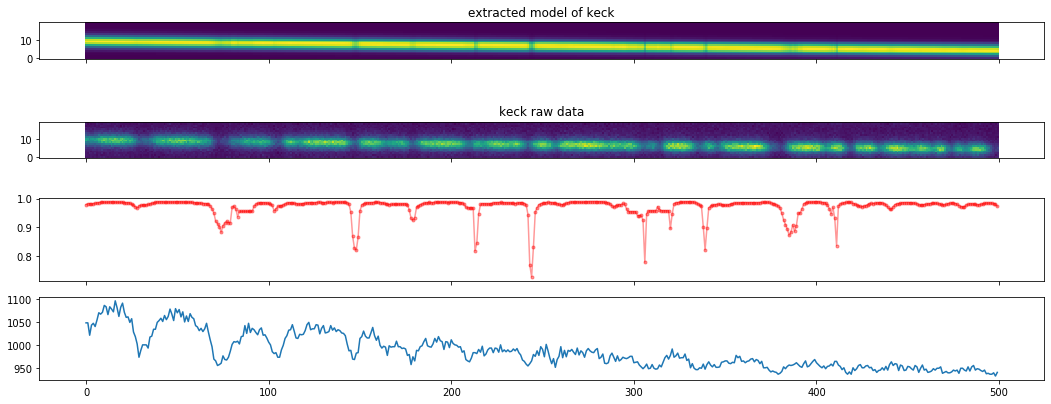

In [61]:
imshowkwargs = {"origin": "lower", "interpolation": "nearest"}
fig, axes = plt.subplots(4, figsize=(18, 7), sharex=True)
axes[0].set_title("extracted model of keck")
# plt.figure(figsize=(5,7))
axes[0].imshow(fhat[400:420, 1000:1500], **imshowkwargs)
axes[1].set_title("keck raw data")
axes[1].imshow(rawfile[1].data.T[400:420, 1000:1500], **imshowkwargs)
# axes[2].set_title("difference")
# axes[2].imshow((fhat[400:420,1000:1500] - rawfile[1].data.T[400:420,1000:1500])*2, **imshowkwargs)


# plt.plot(xs[np.where(trace([],xs,0)[0] > 0)], trace([],xs,0)[0][np.where(trace([],xs,0)[0] > 0)], "r-", alpha=0.5)
# plt.xlim(-0.5, len(xs)-0.5)
# fig.colorbar(cm.plasma(rawfile[1].data.T[400:420,1000:1500]))
# plt.xlabel(r"$x$ (pix)")
# plt.ylabel(r"$y$ (pix)")


# fig, axes = plt.subplots(1,figsize=(18, 3),sharex=True)
axes[2].plot(
    flux_model([], wav_sol([], np.arange(1000, 1500, dtype=int), 0), 0),
    ".-r",
    alpha=0.4,
)
axes[3].plot(rawfile[1].data.T[410, 1000:1500])
# plt.savefig('keck_flux_n_wav.png').

plt.savefig("keck_2d.png", dpi=200)
plt.show()

In [62]:
np.min(rawfile[1].data[1000:4000, 240:290].T), np.max(
    rawfile[1].data[1000:4000, 240:290].T
)

(923, 2216)

Text(0, 0.5, '$y$ (pix)')

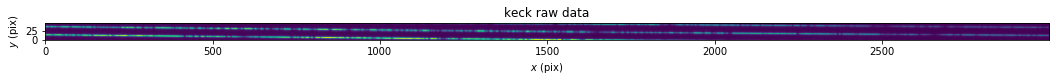

In [63]:
imshowkwargs = {"origin": "lower", "interpolation": "nearest"}
fig, ax = plt.subplots(figsize=(18, 2))
ax.set_title("keck raw data")
# plt.figure(figsize=(5,7))
ax.imshow(rawfile[1].data[1000:4000, 240:290].T, **imshowkwargs)
# plt.plot(xs[np.where(trace([],xs,0)[0] > 0)], trace([],xs,0)[0][np.where(trace([],xs,0)[0] > 0)], "r-", alpha=0.5)
# plt.xlim(-0.5, len(xs)-0.5)
# plt.colorbar()
plt.xlabel(r"$x$ (pix)")
plt.ylabel(r"$y$ (pix)")

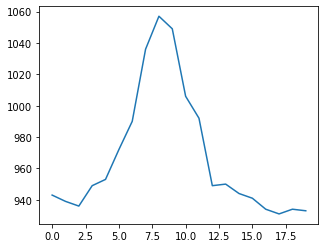

In [64]:
# imshowkwargs = {"origin": "lower", "interpolation": "nearest"}
fig, axes = plt.subplots(1, figsize=(5, 4), sharex=True)
axes.plot(rawfile[1].data.T[400:420, 1100])
plt.savefig("keck_raw_profile.png", dpi=200)
plt.show()